<a href="https://colab.research.google.com/github/00000281892/DynaBiome/blob/main/BenchMark_Comparisons_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
!pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler

# Dataset loading

In [ ]:
# prompt: Load csv file with pandas
import pandas as pd
df_benchmark = pd.read_csv('/content/asv_interpretability_dataset_modified.csv', dtype={'PatientID': str})

In [ ]:
# --- Handle NeutrophilCount with '<0.1' values ---
def parse_neutrophil(value):
    try:
        return float(value)
    except:
        if isinstance(value, str) and "<" in value:
            threshold = float(value.replace("<", "").strip())
            return threshold / 2  # or use threshold itself
        return np.nan

df_benchmark['NeutrophilCount'] = df_benchmark['NeutrophilCount'].apply(parse_neutrophil)

In [ ]:
# One-hot encode stool consistency
df_benchmark = pd.get_dummies(df_benchmark, columns=['Consistency'])

In [ ]:
# Log transform Genus-relative abundances
df_benchmark['RelativeAbundance'] = df_benchmark['RelativeAbundance'].astype(float)
df_benchmark['RelativeAbundance'] = np.log1p(df_benchmark['RelativeAbundance'])

In [ ]:
def label_dysbiosis(row):
    is_temp_abnormal = row['MaxTemperature'] > 38.0
    is_neutro_low = row['NeutrophilCount'] < 500
    is_consistency_liquid = row.get('Consistency_liquid', 0) == 1
    return int(is_temp_abnormal and is_neutro_low and is_consistency_liquid)

In [ ]:
df_benchmark['DysbiosisLabel'] = df_benchmark.apply(label_dysbiosis, axis=1)

In [ ]:
# Keep metadata along with abundances
metadata_cols = ['PatientID', 'SampleID', 'DayRelativeToNearestHCT',
                 'MaxTemperature', 'NeutrophilCount'] + \
                [col for col in df_benchmark.columns if col.startswith('Consistency_')] + \
                ['DysbiosisLabel']

In [ ]:
genus_pivot = df_benchmark.pivot_table(
    index=['PatientID', 'SampleID', 'DayRelativeToNearestHCT'],
    columns='Genus',
    values='RelativeAbundance',
    fill_value=0
).reset_index()

In [ ]:
# Merge with metadata
metadata = df_benchmark[metadata_cols].drop_duplicates(subset=['PatientID', 'SampleID', 'DayRelativeToNearestHCT'])
merged_df_benchmark = pd.merge(genus_pivot, metadata, on=['PatientID', 'SampleID', 'DayRelativeToNearestHCT'], how='left')

In [ ]:
# Drop genus columns with zero variance
genus_cols = df_benchmark['Genus'].unique().tolist()
variances = merged_df_benchmark[genus_cols].var()
non_zero_var_cols = variances[variances > 1e-6].index.tolist()

In [ ]:
# Final feature set
feature_cols = non_zero_var_cols + ['MaxTemperature', 'NeutrophilCount'] + \
               [col for col in merged_df_benchmark.columns if 'Consistency' in col]

In [ ]:
# ==================== STEP 2: Scaling ====================
scaler = MinMaxScaler()
merged_df_benchmark[feature_cols] = scaler.fit_transform(merged_df_benchmark[feature_cols])

In [ ]:
# ==================== STEP 3: Prepare Time Series ====================
# Sort & reshape by patient and day
merged_df_benchmark = merged_df_benchmark.sort_values(['PatientID', 'DayRelativeToNearestHCT'])

In [ ]:
# --- [1] Build sequences with labels ---
def build_sequences_with_labels(df, feature_cols, label_col='DysbiosisLabel', seq_len=14):
    X_sequences = []
    y_labels = []
    time_indices = []

    for pid, group in df.groupby('PatientID'):
        group = group.sort_values('DayRelativeToNearestHCT')
        values = group[feature_cols].values
        labels = group[label_col].values
        days = group['DayRelativeToNearestHCT'].values

        for i in range(len(values) - seq_len + 1):
            seq = values[i:i+seq_len]
            label_window = labels[i:i+seq_len]
            label = int(label_window.max())  # 1 if any point in window is dysbiotic
            time = days[i+seq_len-1]  # assign the last day of the window
            X_sequences.append(seq)
            y_labels.append(label)
            time_indices.append((pid, time))

    return np.array(X_sequences), np.array(y_labels), time_indices

In [ ]:
# --- [2] Define features ---
seq_len = 14
feature_cols = [col for col in merged_df_benchmark.columns
                if col not in ['PatientID', 'SampleID', 'DayRelativeToNearestHCT',
                               'DysbiosisLabel', 'MaxTemperature', 'NeutrophilCount']
                and not col.startswith('Consistency_')]

# --- [3] Build sequences ---
X_seq, y_seq, time_idx = build_sequences_with_labels(merged_df_benchmark, feature_cols, seq_len=seq_len)

# Time based Splitting

In [ ]:
# --- [4] Create DataFrame for temporal splitting ---
split_df = pd.DataFrame(time_idx, columns=['PatientID', 'DayRelativeToNearestHCT'])
split_df['y'] = y_seq
split_df['X_idx'] = range(len(X_seq))

In [ ]:
# --- [5] Sort by patient and time ---
split_df = split_df.sort_values(['PatientID', 'DayRelativeToNearestHCT'])

In [ ]:
# --- [6] Determine split indices (70/15/15 by number of sequences) ---
n_total = len(split_df)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

In [ ]:
train_idx = split_df.iloc[:n_train]['X_idx'].values
val_idx = split_df.iloc[n_train:n_train+n_val]['X_idx'].values
test_idx = split_df.iloc[n_train+n_val:]['X_idx'].values

In [ ]:
# --- [7] Final splits ---
X_train, y_train = X_seq[train_idx], y_seq[train_idx]
X_val, y_val = X_seq[val_idx], y_seq[val_idx]
X_test, y_test = X_seq[test_idx], y_seq[test_idx]

In [ ]:
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (49781, 14, 412), Validation: (10667, 14, 412), Test: (10669, 14, 412)


In [ ]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

In [ ]:
input_layer = Input(shape=(n_features,))  # Should match (None, 412)
print(input_layer.shape)

(None, 412)


In [ ]:
X_train_reshaped = X_train.reshape(-1, n_features)  # Flatten time steps
X_val_reshaped = X_val.reshape(-1, n_features)
print(X_train_reshaped.shape)
print(X_val_reshaped.shape)

(696934, 412)
(149338, 412)


In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

# Food Allergy Autoencoder

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define input dimensions
input_dim = n_features  # Number of microbiome features

# Sparsity Constraint (KL Divergence)
rho = 0.01  # Desired average activation
beta = 3    # Weight of sparsity penalty

# Define a custom activity regularizer for KL Divergence
class KLDivergenceRegularizer(regularizers.Regularizer):
    def __init__(self, rho, beta):
        self.rho = rho
        self.beta = beta

    def __call__(self, x):
        # x is the output of the layer it's attached to
        rho_hat = K.mean(x, axis=0)
        # Add a small epsilon for numerical stability to prevent log(0)
        rho_hat = K.clip(rho_hat, K.epsilon(), 1 - K.epsilon())
        kl_div = self.rho * K.log(self.rho / rho_hat) + (1 - self.rho) * K.log((1 - rho_hat) / (1 - self.rho))
        return self.beta * K.sum(kl_div)

    def get_config(self):
        return {'rho': self.rho, 'beta': self.beta}


# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05))(input_layer)
# Apply the custom activity regularizer to the layer you want to be sparse
encoded_sparse_layer = Dense(
    25,
    activation='relu',
    name='sparse_layer',
    activity_regularizer=KLDivergenceRegularizer(rho, beta) # Apply sparsity here
)(encoded)
encoded = Dense(60, activation='relu')(encoded_sparse_layer)

# Decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)  # Output layer reconstructs input

# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile Autoencoder with Reconstruction Loss (MSE)
# The activity regularizer penalty is automatically added by Keras
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train the model with batch size = 5 and epochs = 300
# Define early stopping callback
# Stop training when validation loss has not improved for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model with early stopping
autoencoder.fit(
        X_train_reshaped, X_train_reshaped,
        epochs=300, # Set a reasonably high number, early stopping will stop it sooner
        batch_size=64,
        validation_data=(X_val_reshaped, X_val_reshaped),
        callbacks=[early_stopping], # Add the callback here
        verbose=1
    )

Epoch 1/300
10890/10890 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: -1123.2030 - val_loss: -1186.4283
Epoch 2/300
10890/10890 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: -1186.4249 - val_loss: -1186.4283
Epoch 3/300
10890/10890 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: -1186.4248 - val_loss: -1186.4283
Epoch 4/300
10890/10890 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: -1186.4226 - val_loss: -1186.4066
Epoch 5/300
10890/10890 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: -1186.3632 - val_loss: -1186.4283
Epoch 6/300
10890/10890 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: -1186.4248 - val_loss: -1186.4283
Epoch 7/300
10890/10890 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: -1186.4078 - val_loss: -1186.4276
Epoch 8/300
10890/10890 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: -1186.4180 - val_loss: -1186.4279
Epoch 9/300
10890/10890 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: -1186.4180 - val_loss: -1186.4283
Epoch 10/300
10890/10890 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: -1186.4242 - val_loss: -1186.4277

In [ ]:
import os

# Define the directory to save the model
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Define the path to save the autoencoder model
model_path = os.path.join(save_dir, "sparse_autoencoder_model.keras")

# Save the entire model (architecture, weights, optimizer state, and custom objects)
# Using the default SavedModel format
autoencoder.save(model_path)

print(f"Model saved to {model_path}")

Model saved to saved_models/sparse_autoencoder_model.keras


In [ ]:
# Print summary
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 412)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 60)             │        24,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sparse_layer (Dense)            │ (None, 25)             │         1,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 60)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 412)            │        25,132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,993 (621.07 KB)

 Trainable params: 52,997 (207.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,996 (414.05 KB)

In [ ]:
X_train_reshaped = X_train.reshape(-1, n_features)  # Flatten time steps
X_val_reshaped = X_val.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)
print(X_train_reshaped.shape)
print(X_val_reshaped.shape)
print(X_test_reshaped.shape)

(696934, 412)
(149338, 412)
(149366, 412)


In [ ]:
# Assuming 'autoencoder' is your trained model from the previous steps
# And 'encoded_sparse_layer' is the output tensor of the sparse layer

# 1. Create the Encoder Model
# Define the input to the encoder (same as autoencoder input)
encoder_input = autoencoder.input
# Define the output of the encoder (the output of the sparse layer by name)
# Find the sparse layer by name
sparse_layer_output = autoencoder.get_layer('sparse_layer').output

# Create the encoder model
encoder_model = Model(inputs=encoder_input, outputs=sparse_layer_output)

# Print the summary to verify the encoder structure
print("\nEncoder Model Summary:")
encoder_model.summary()

# 2. Use the Encoder to Transform Your Data
# Apply the encoder model to your original 3D time series data (X_train, X_val, X_test)
# Note: The encoder expects 2D input (samples, features), so we need to apply it
# to the reshaped data and then reshape the output back to 3D if needed for LSTM.

# Transform the reshaped data first
X_train_encoded_reshaped = encoder_model.predict(X_train_reshaped)
X_val_encoded_reshaped = encoder_model.predict(X_val_reshaped)
X_test_encoded_reshaped = encoder_model.predict(X_test_reshaped)

# X_train_encoded_reshaped now has shape (num_sequences * seq_len, sparse_features_dim)
# We need to reshape it back to the original 3D structure for the LSTM
# (num_sequences, seq_len, sparse_features_dim)

seq_len = 14 # Your defined sequence length
sparse_features_dim = X_train_encoded_reshaped.shape[-1] # Should be 25 based on your autoencoder

X_train_encoded = X_train_encoded_reshaped.reshape(-1, seq_len, sparse_features_dim)
X_val_encoded = X_val_encoded_reshaped.reshape(-1, seq_len, sparse_features_dim)
X_test_encoded = X_test_encoded_reshaped.reshape(-1, seq_len, sparse_features_dim)

print(f"\nOriginal X_train shape: {X_train.shape}")
print(f"Encoded X_train shape: {X_train_encoded.shape}")
print(f"Original X_val shape: {X_val.shape}")
print(f"Encoded X_val shape: {X_val_encoded.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"Encoded X_test shape: {X_test_encoded.shape}")

# 3. Build and Train Your LSTM Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

# Define LSTM model architecture
lstm_model = Sequential([
    Input(shape=(seq_len, sparse_features_dim)), # Input shape is (timesteps, features)
    LSTM(64, return_sequences=False), # LSTM layer, return_sequences=False for many-to-one prediction
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification (dysbiosis)
])

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print LSTM model summary
print("\nLSTM Model Summary:")
lstm_model.summary()

# Monitor validation loss and stop if it doesn't improve for, say, 15 epochs
lstm_early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Increased patience slightly as an example


# Train the LSTM model using the encoded features and original labels (y_train, y_val)
print("\nTraining LSTM Model:")
lstm_model.fit(
    X_train_encoded, y_train,
    epochs=50, # Or use EarlyStopping
    batch_size=64,
    validation_data=(X_val_encoded, y_val),
    callbacks=[lstm_early_stopping],
    verbose=1
)

# 4. Evaluate the LSTM Model
loss, accuracy = lstm_model.evaluate(X_test_encoded, y_test, verbose=0)
print(f"\nLSTM Test Loss: {loss:.4f}, LSTM Test Accuracy: {accuracy:.4f}")


Encoder Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 412)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │        24,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sparse_layer (Dense)            │ (None, 25)             │         1,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,305 (102.75 KB)

 Trainable params: 26,305 (102.75 KB)

 Non-trainable params: 0 (0.00 B)

21780/21780 ━━━━━━━━━━━━━━━━━━━━ 15s 688us/step
4667/4667 ━━━━━━━━━━━━━━━━━━━━ 3s 685us/step
4668/4668 ━━━━━━━━━━━━━━━━━━━━ 3s 678us/step

Original X_train shape: (49781, 14, 412)
Encoded X_train shape: (49781, 14, 25)
Original X_val shape: (10667, 14, 412)
Encoded X_val shape: (10667, 14, 25)
Original X_test shape: (10669, 14, 412)
Encoded X_test shape: (10669, 14, 25)

LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,153 (98.25 KB)

 Trainable params: 25,153 (98.25 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model:
Epoch 1/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7804 - loss: 0.5297 - val_accuracy: 0.7806 - val_loss: 0.5287
Epoch 2/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7797 - loss: 0.5283 - val_accuracy: 0.7806 - val_loss: 0.5262
Epoch 3/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7818 - loss: 0.5253 - val_accuracy: 0.7806 - val_loss: 0.5267
Epoch 4/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7844 - loss: 0.5220 - val_accuracy: 0.7806 - val_loss: 0.5262
Epoch 5/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7814 - loss: 0.5255 - val_accuracy: 0.7806 - val_loss: 0.5261
Epoch 6/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7814 - loss: 0.5256 - val_accuracy: 0.7806 - val_loss: 0.5273
Epoch 7/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7778 - loss: 0.5301 - val_accuracy: 0.7806 - val_loss: 0.5269
Epoch 8/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7791 - loss: 0.5

334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      6159
           1       1.00      0.00      0.00      4510

    accuracy                           0.58     10669
   macro avg       0.79      0.50      0.37     10669
weighted avg       0.76      0.58      0.42     10669

ROC AUC: 0.5863


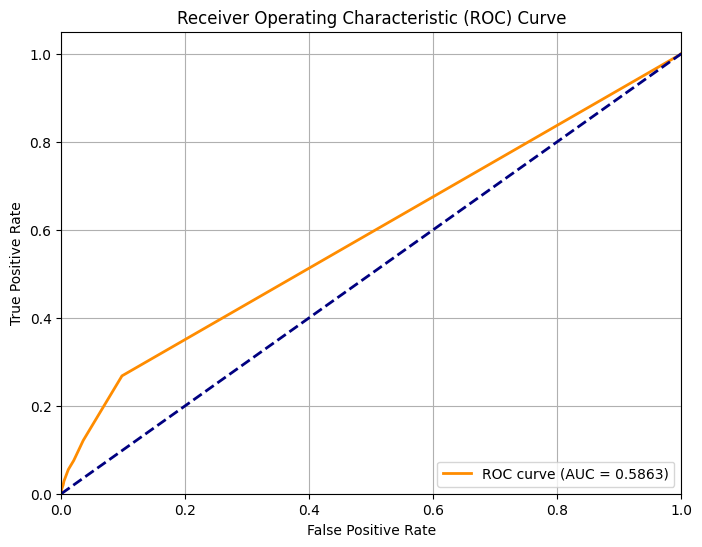

Average Precision (PR AUC): 0.5003


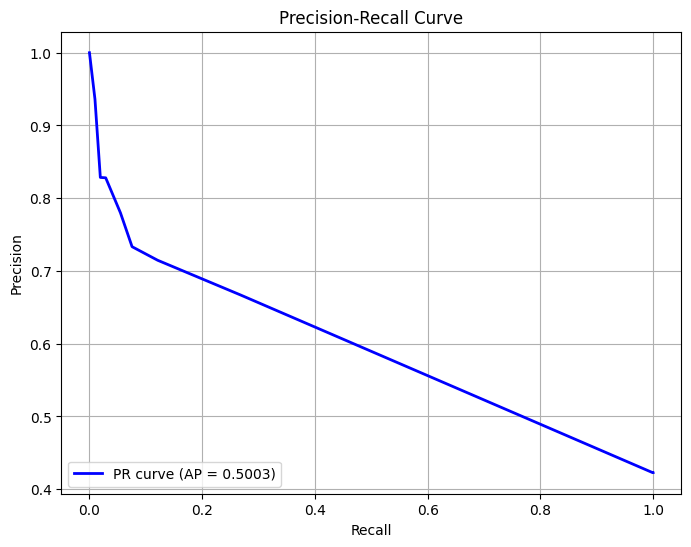

In [ ]:
# prompt: Print Classification Reports, RoC (AUC), PR Curve and all relevant metrics

from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 5. Make Predictions on the Test Set
y_pred_proba = lstm_model.predict(X_test_encoded).ravel() # Get probabilities and flatten
y_pred_class = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary class predictions

# 6. Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, zero_division=1))

# 7. Calculate and Print ROC AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

# 8. Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 9. Calculate and Print Average Precision Score (PR AUC)
average_precision = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision (PR AUC): {average_precision:.4f}")

# 10. Plot Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [ ]:
# 11. Print Additional Relevant Metrics (from classification report)
print("\nAdditional Metrics:")
report_dict = classification_report(y_test, y_pred_class, output_dict=True,zero_division=1)
print(f"Accuracy: {report_dict['accuracy']:.4f}")
# For the positive class (assuming label 1 is positive)
if '1' in report_dict:
    print(f"Precision (Class 1): {report_dict['1']['precision']:.4f}")
    print(f"Recall (Class 1): {report_dict['1']['recall']:.4f}")
    print(f"F1-Score (Class 1): {report_dict['1']['f1-score']:.4f}")
# For the negative class (assuming label 0 is negative)
if '0' in report_dict:
    print(f"Precision (Class 0): {report_dict['0']['precision']:.4f}")
    print(f"Recall (Class 0): {report_dict['0']['recall']:.4f}")
    print(f"F1-Score (Class 0): {report_dict['0']['f1-score']:.4f}")

print(f"Macro Avg Precision: {report_dict['macro avg']['precision']:.4f}")
print(f"Macro Avg Recall: {report_dict['macro avg']['recall']:.4f}")
print(f"Macro Avg F1-Score: {report_dict['macro avg']['f1-score']:.4f}")

print(f"Weighted Avg Precision: {report_dict['weighted avg']['precision']:.4f}")
print(f"Weighted Avg Recall: {report_dict['weighted avg']['recall']:.4f}")
print(f"Weighted Avg F1-Score: {report_dict['weighted avg']['f1-score']:.4f}")


Additional Metrics:
Accuracy: 0.5773
Precision (Class 1): 1.0000
Recall (Class 1): 0.0000
F1-Score (Class 1): 0.0000
Precision (Class 0): 0.5773
Recall (Class 0): 1.0000
F1-Score (Class 0): 0.7320
Macro Avg Precision: 0.7886
Macro Avg Recall: 0.5000
Macro Avg F1-Score: 0.3660
Weighted Avg Precision: 0.7560
Weighted Avg Recall: 0.5773
Weighted Avg F1-Score: 0.4226


# SelectKBest Feature Selection Algorithm

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have your X_train, X_val, X_test, y_train, y_val, y_test
# and seq_len defined from your previous code.

print("\n--- Implementing Feature Selection using SelectKBest on Original Features ---")


--- Implementing Feature Selection using SelectKBest on Original Features ---


In [ ]:
# Step 1: Prepare data for SelectKBest by averaging ORIGINAL features over time steps
# X_train is shape (num_sequences, seq_len, n_features)
X_train_original_avg_for_selection = np.mean(X_train, axis=1) # Shape (num_sequences, n_features)
y_selection_original = y_train # Use the original sequence labels (num_sequences,)

# Number of features to select from the original feature space
k_features_original_selection = 50 # You can adjust this number

print(f"Applying SelectKBest to select {k_features_original_selection} features from {X_train_original_avg_for_selection.shape[1]} original features (averaged over sequence)...")

Applying SelectKBest to select 50 features from 412 original features (averaged over sequence)...


In [ ]:
# Step 2: Apply SelectKBest
# Use mutual_info_classif as the scoring function
selector_original = SelectKBest(score_func=mutual_info_classif, k=k_features_original_selection)

# Fit on the training data (averaged original features and sequence labels)
# Handle the case where y_train might be constant
if len(np.unique(y_selection_original)) < 2:
    print("Warning: Target variable is constant in the training set. Skipping SelectKBest selection.")
    # Select all features as a fallback if the target is constant
    selected_feature_indices_original_selection = list(range(X_train_original_avg_for_selection.shape[1]))
    print("Selecting all original features as a fallback.")
else:
    selector_original.fit(X_train_original_avg_for_selection, y_selection_original)

    # Get the indices of the selected features
    selected_feature_indices_original_selection = selector_original.get_support(indices=True)


print(f"Selected feature indices from original feature space by SelectKBest: {selected_feature_indices_original_selection}")
print(f"Number of selected features: {len(selected_feature_indices_original_selection)}")

Selected feature indices from original feature space by SelectKBest: [  1  12  19  21  23  37  45  47  50  54  91 109 131 137 140 145 150 153
 161 167 168 175 194 202 221 222 229 238 250 276 283 284 289 322 325 340
 345 351 361 365 366 372 378 382 386 389 394 396 407 408]
Number of selected features: 50


In [ ]:
# Step 3: Use these selected ORIGINAL features to subset the time series data (apply to train, val, test)
# Select the features from the original 3D time series data using the indices
# X_data is shape (num_sequences, seq_len, n_features)
X_train_original_selected = X_train[:, :, selected_feature_indices_original_selection]
X_val_original_selected = X_val[:, :, selected_feature_indices_original_selection]
X_test_original_selected = X_test[:, :, selected_feature_indices_original_selection]

print(f"\nOriginal and SelectKBest-selected X_train shape: {X_train_original_selected.shape}")
print(f"Original and SelectKBest-selected X_val shape: {X_val_original_selected.shape}")
print(f"Original and SelectKBest-selected X_test shape: {X_test_original_selected.shape}")


Original and SelectKBest-selected X_train shape: (49781, 14, 50)
Original and SelectKBest-selected X_val shape: (10667, 14, 50)
Original and SelectKBest-selected X_test shape: (10669, 14, 50)


In [ ]:
# Assuming 'feature_cols' contains the names of the original features used to create X_train, X_val, X_test
# This variable should have been defined earlier in the notebook during data preprocessing.
# If not, you'll need to ensure 'feature_cols' is available and correctly lists the column names
# that correspond to the feature dimension of X_train (the last dimension).

# Retrieve the names of the selected features
original_feature_names = feature_cols # Use the list of original feature names
selected_feature_names = [original_feature_names[i] for i in selected_feature_indices_original_selection]

print("\nSelected Feature Names (from original features):")
print(selected_feature_names)
print(f"\nNumber of selected features: {len(selected_feature_names)}")


Selected Feature Names (from original features):
['<not present>', 'Actinomyces', 'Agathobacter', 'Akkermansia', 'Alistipes', 'Anaerostipes', 'Atopobium', 'Bacteroides', 'Bifidobacterium', 'Blautia', 'Clostridium sensu stricto 1', 'Corynebacterium 1', 'Eggerthella', 'Enterococcus', 'Erysipelatoclostridium', 'Escherichia-Shigella', 'Faecalibacterium', 'Faecalitalea', 'Flavonifractor', 'Fusicatenibacter', 'Fusobacterium', 'Gemella', 'Intestinibacter', 'Lachnoclostridium', 'Lactobacillus', 'Lactococcus', 'Leuconostoc', 'Megasphaera', 'Mogibacterium', 'Parabacteroides', 'Parvimonas', 'Pediococcus', 'Phascolarctobacterium', 'Rothia', 'Ruminiclostridium 5', 'Ruminococcus 2', 'Scardovia', 'Sellimonas', 'Staphylococcus', 'Streptococcus', 'Subdoligranulum', 'Terrisporobacter', 'Turicibacter', 'UBA1819', 'Veillonella', 'Weissella', '[Clostridium] innocuum group', '[Eubacterium] coprostanoligenes group', '[Ruminococcus] gnavus group', '[Ruminococcus] torques group']

Number of selected features:

In [ ]:
# Step 4: Build and Train a new LSTM Model with SelectKBest-selected ORIGINAL features
n_features_original_selected = X_train_original_selected.shape[-1] # This will be k_features_original_selection
# seq_len is already defined

# Define LSTM model architecture for selected ORIGINAL features
lstm_model_original_selected = Sequential([
    Input(shape=(seq_len, n_features_original_selected)), # Input shape adjusted
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the LSTM model
lstm_model_original_selected.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print LSTM model summary
print("\nLSTM Model Summary (with SelectKBest Original features):")
lstm_model_original_selected.summary()

# Define early stopping callback
lstm_early_stopping_original_selected = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the LSTM model
print("\nTraining LSTM Model (with SelectKBest Original features):")
lstm_model_original_selected.fit(
    X_train_original_selected, y_train,
    epochs=50, # Or use EarlyStopping
    batch_size=64,
    validation_data=(X_val_original_selected, y_val),
    callbacks=[lstm_early_stopping_original_selected],
    verbose=1
)


LSTM Model Summary (with SelectKBest Original features):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,553 (123.25 KB)

 Trainable params: 31,553 (123.25 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model (with SelectKBest Original features):
Epoch 1/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8313 - loss: 0.3714 - val_accuracy: 0.8209 - val_loss: 0.3319
Epoch 2/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8618 - loss: 0.2631 - val_accuracy: 0.8121 - val_loss: 0.3283
Epoch 3/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8667 - loss: 0.2478 - val_accuracy: 0.8276 - val_loss: 0.3259
Epoch 4/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8712 - loss: 0.2402 - val_accuracy: 0.8334 - val_loss: 0.3249
Epoch 5/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8746 - loss: 0.2370 - val_accuracy: 0.8353 - val_loss: 0.3248
Epoch 6/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8811 - loss: 0.2270 - val_accuracy: 0.8242 - val_loss: 0.3311
Epoch 7/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8867 - loss: 0.2194 - val_accuracy: 0.8178 - val_loss: 0.3518
Epoch 8/50
778/778 ━━━━━━━━━━━━━━━━━━━━ 7s 9m

In [ ]:
# Step 5: Evaluate the SelectKBest-based LSTM Model (Original Features)
print("\nEvaluating LSTM Model on Test Set...")
loss_original_selected, accuracy_original_selected = lstm_model_original_selected.evaluate(X_test_original_selected, y_test, verbose=0)
print(f"\nLSTM (SelectKBest Original Features) Test Loss: {loss_original_selected:.4f}, LSTM Test Accuracy: {accuracy_original_selected:.4f}")


Evaluating LSTM Model on Test Set...

LSTM (SelectKBest Original Features) Test Loss: 0.5025, LSTM Test Accuracy: 0.7468



Generating Classification Report and Plots...
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report (SelectKBest Original Features):
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      6159
           1       0.73      0.63      0.68      4510

    accuracy                           0.75     10669
   macro avg       0.74      0.73      0.73     10669
weighted avg       0.75      0.75      0.74     10669

ROC AUC (SelectKBest Original Features): 0.8332


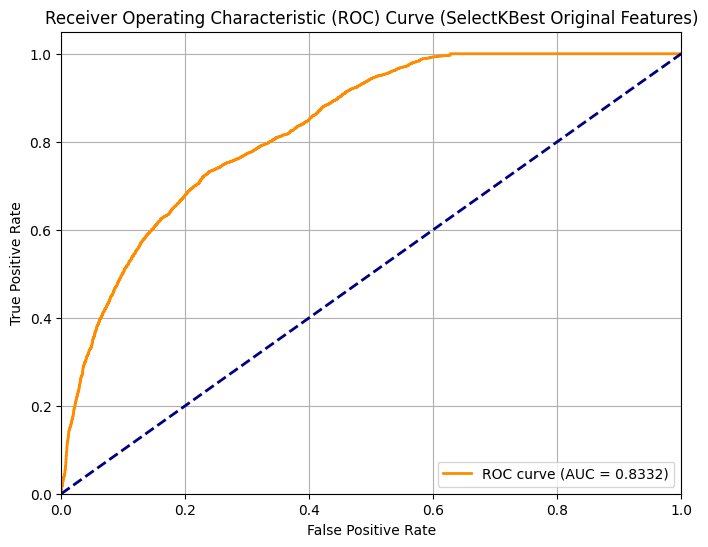

Average Precision (PR AUC) (SelectKBest Original Features): 0.7629


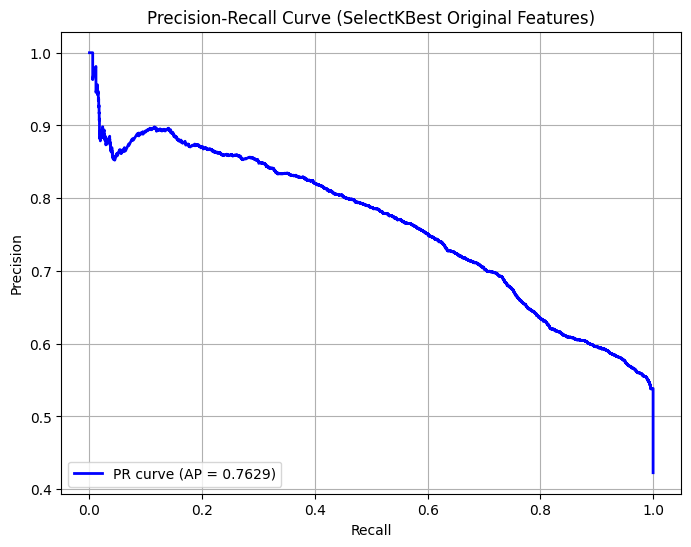


Additional Metrics (SelectKBest Original Features):
Accuracy: 0.7468
Precision (Class 1): 0.7328
Recall (Class 1): 0.6313
F1-Score (Class 1): 0.6783
Precision (Class 0): 0.7549
Recall (Class 0): 0.8315
F1-Score (Class 0): 0.7913
Macro Avg Precision: 0.7438
Macro Avg Recall: 0.7314
Macro Avg F1-Score: 0.7348
Weighted Avg Precision: 0.7455
Weighted Avg Recall: 0.7468
Weighted Avg F1-Score: 0.7435

Weighted F1 Score (SelectKBest Original Features): 0.7435


In [ ]:
# Step 6: Make Predictions and Report Detailed Metrics for SelectKBest original model
print("\nGenerating Classification Report and Plots...")
y_pred_proba_original_selected = lstm_model_original_selected.predict(X_test_original_selected).ravel() # Get probabilities
y_pred_class_original_selected = (y_pred_proba_original_selected > 0.5).astype(int) # Convert to binary classes

# Print Classification Report
print("\nClassification Report (SelectKBest Original Features):")
print(classification_report(y_test, y_pred_class_original_selected, zero_division=1))

# Calculate and Print ROC AUC
fpr_original_selected, tpr_original_selected, thresholds_roc_original_selected = roc_curve(y_test, y_pred_proba_original_selected)
roc_auc_original_selected = auc(fpr_original_selected, tpr_original_selected)
print(f"ROC AUC (SelectKBest Original Features): {roc_auc_original_selected:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_original_selected, tpr_original_selected, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_original_selected:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (SelectKBest Original Features)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate and Print Average Precision Score (PR AUC)
average_precision_original_selected = average_precision_score(y_test, y_pred_proba_original_selected)
print(f"Average Precision (PR AUC) (SelectKBest Original Features): {average_precision_original_selected:.4f}")

# Plot Precision-Recall Curve
precision_original_selected, recall_original_selected, thresholds_pr_original_selected = precision_recall_curve(y_test, y_pred_proba_original_selected)
plt.figure(figsize=(8, 6))
plt.plot(recall_original_selected, precision_original_selected, color='blue', lw=2, label=f'PR curve (AP = {average_precision_original_selected:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (SelectKBest Original Features)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Print Additional Relevant Metrics
print("\nAdditional Metrics (SelectKBest Original Features):")
report_dict_original_selected = classification_report(y_test, y_pred_class_original_selected, output_dict=True, zero_division=1)
print(f"Accuracy: {report_dict_original_selected.get('accuracy', 'N/A'):.4f}")

if '1' in report_dict_original_selected:
    print(f"Precision (Class 1): {report_dict_original_selected['1'].get('precision', 'N/A'):.4f}")
    print(f"Recall (Class 1): {report_dict_original_selected['1'].get('recall', 'N/A'):.4f}")
    print(f"F1-Score (Class 1): {report_dict_original_selected['1'].get('f1-score', 'N/A'):.4f}")

if '0' in report_dict_original_selected:
    print(f"Precision (Class 0): {report_dict_original_selected['0'].get('precision', 'N/A'):.4f}")
    print(f"Recall (Class 0): {report_dict_original_selected['0'].get('recall', 'N/A'):.4f}")
    print(f"F1-Score (Class 0): {report_dict_original_selected['0'].get('f1-score', 'N/A'):.4f}")

if 'macro avg' in report_dict_original_selected:
    print(f"Macro Avg Precision: {report_dict_original_selected['macro avg'].get('precision', 'N/A'):.4f}")
    print(f"Macro Avg Recall: {report_dict_original_selected['macro avg'].get('recall', 'N/A'):.4f}")
    print(f"Macro Avg F1-Score: {report_dict_original_selected['macro avg'].get('f1-score', 'N/A'):.4f}")

if 'weighted avg' in report_dict_original_selected:
    print(f"Weighted Avg Precision: {report_dict_original_selected['weighted avg'].get('precision', 'N/A'):.4f}")
    print(f"Weighted Avg Recall: {report_dict_original_selected['weighted avg'].get('recall', 'N/A'):.4f}")
    print(f"Weighted Avg F1-Score: {report_dict_original_selected['weighted avg'].get('f1-score', 'N/A'):.4f}")

f1_original_selected = f1_score(y_test, y_pred_class_original_selected, average='weighted')
print(f"\nWeighted F1 Score (SelectKBest Original Features): {f1_original_selected:.4f}")

# To Load the model later

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import regularizers # Make sure this is imported when loading

# Define the custom regularizer class again (or import it if in a separate file)
# Keras needs the class definition to load the custom object correctly
class KLDivergenceRegularizer(regularizers.Regularizer):
    def __init__(self, rho, beta):
        self.rho = rho
        self.beta = beta

    def __call__(self, x):
        rho_hat = K.mean(x, axis=0)
        rho_hat = K.clip(rho_hat, K.epsilon(), 1 - K.epsilon())
        kl_div = self.rho * K.log(self.rho / rho_hat) + (1 - self.rho) * K.log((1 - rho_hat) / (1 - rho))
        return self.beta * K.sum(kl_div)

    def get_config(self):
        return {'rho': self.rho, 'beta': self.beta}

# Define the path where the model was saved
model_path = "saved_models/sparse_autoencoder_model"

# Load the model, providing the custom object
loaded_autoencoder = load_model(
    model_path,
    custom_objects={'KLDivergenceRegularizer': KLDivergenceRegularizer}
)

print("Model loaded successfully.")
loaded_autoencoder.summary()